In [27]:
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
from bokeh.plotting import show, figure
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [28]:
data = pd.read_csv("Family_Income_and_Expenditure.csv") 

In [ ]:
pd.set_option('display.max_columns', 60)
data.head(3)

# 2. Model 1 - Linear Regression

## 2.1. Model only with numeric data

In [3]:
# spliting data in numeric and text
colnumber = len(data.columns)
data_number = pd.DataFrame()
data_text = pd.DataFrame()
for i in range(colnumber):
    if data.dtypes[i] == "int64":
        data_number[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])
    else:
        data_text[[data.columns[i]]] = pd.DataFrame(data.iloc[:,i])

### 2.1.1. Making new variables

**Transformations that could help improve model:**

   +  count sum of things which in data set start with “Number of ...” (for example: “Number of Television”, “Number of CD/VCD/DVD” and so on.);
   + sum all expenses (“Total Expenditure”);
   + sum just other expenses, excluding food expenses (“Other Expenditure”);
   + sum all food expenses “Food Expenditure”;
   + calculate ratio between “Food Expenditure” and “Total Expenditure”;
   + calculate ratio between “Other Expenditure” and “Total Expenditure”;
   + calculate ratio between “Total Number of Family members” and “Number of bedrooms”;

#### <font color='red'> don't work with last culumn</font>

In [4]:
data_number2 = pd.DataFrame()
data_number2["Number of (all)"] = data_number.iloc[:, 32:45].sum(axis = 1) + data_number["Number of bedrooms"]
data_number2["Other Expenditure"] = data_number["Restaurant and hotels Expenditure"] + data_number["Tobacco Expenditure"] + data_number["Alcoholic Beverages Expenditure"] + data_number["Clothing, Footwear and Other Wear Expenditure"] + data_number["Housing and water Expenditure"] + data_number.iloc[:,15:22].sum(axis = 1)
data_number2["Food Expenditure"] = data_number.iloc[:, 3:9].sum(axis = 1)
data_number2["Total Expenditure"] = data_number.iloc[:, 3:22].drop("Imputed House Rental Value", axis = 1).sum(axis = 1)
data_number2["Food Ex/Total Ex"] = data_number2["Food Expenditure"] / data_number2["Total Expenditure"]
data_number2["Other Ex/Total Ex"] = data_number2["Other Expenditure"] / data_number2["Total Expenditure"]
#data_number2["Members/Bedroom"] = data_number["Total Number of Family members"] / data_number["Number of bedrooms"]

# Ask about commented column

In [5]:
data_number2.head(3)

,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex
0,11,179182,138707,317889,0.436338,0.563662
1,12,117122,68712,185834,0.369749,0.630251
2,1,34604,82081,116685,0.703441,0.296559


In [6]:
data_number3 = pd.DataFrame()
data_number3 = pd.concat([data_number, data_number2], axis = 1)

### 2.1.2. First Model

#### Without Agricultural Household indicator

In [7]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_number.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number[mask].shape, data_number[~mask].shape))

Train set shape (29197, 45), test set shape (12347, 45)


In [8]:
data_number_scaled = data_number.drop(["Agricultural Household indicator"], axis=1)
mean = data_number_scaled[mask].mean()
std = data_number_scaled[mask].std()
# Standard scaler
data_number_scaled = (data_number_scaled - mean) / std

In [9]:
data_number_scaled.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,Number of Refrigerator/Freezer,Number of Washing Machine,Number of Airconditioner,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,...,1.135635,1.422084,-0.289952,-0.232891,-0.219185,0.060683,0.929406,-0.382383,-0.103874,1.269257
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,...,-0.738391,1.422084,-0.289952,-0.232891,-0.219185,0.703555,0.929406,-0.382383,-0.103874,3.059869
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,...,-0.738391,-0.670476,-0.289952,-0.232891,-0.219185,-1.225061,-0.424477,-0.382383,-0.103874,-0.521355


In [10]:
lr = LinearRegression()
lr.fit(data_number_scaled.iloc[mask, 1:], data_number_scaled[mask]["Total Household Income"])
pred = lr.predict(data_number_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_scaled[~mask]["Total Household Income"])**2))))

RMSE = 0.5503


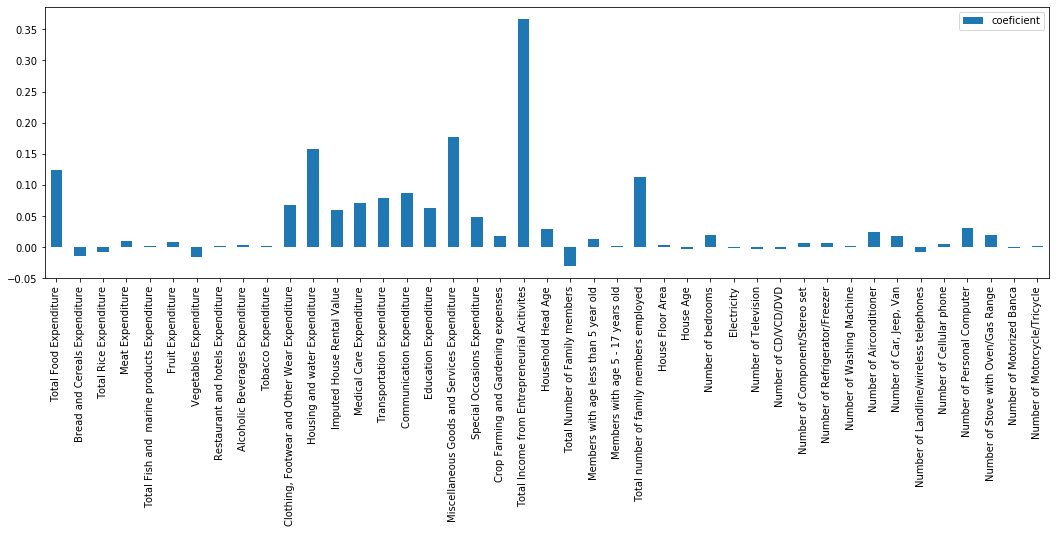

In [11]:
pd.DataFrame(lr.coef_, columns=['coeficient'], 
             index=data_number_scaled[mask].drop(["Total Household Income"], 
                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))

The most important regresion coeficient is "Total Income from Entrepreneurial Acitivites", second one is "Miscellaneous Goods and Services Expenditure"

#### With Agricultural Household indicator

In [12]:
data_number_a = pd.get_dummies(data_number, columns=["Agricultural Household indicator"])

In [13]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_number_a.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number_a[mask].shape, data_number_a[~mask].shape))

Train set shape (29197, 47), test set shape (12347, 47)


In [14]:
mean = data_number_a[mask].mean()
std = data_number_a[mask].std()
# Standard scaler
data_number_a = (data_number_a - mean) / std

In [15]:
data_number_a.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,"Number of Car, Jeep, Van",Number of Landline/wireless telephones,Number of Cellular phone,Number of Personal Computer,Number of Stove with Oven/Gas Range,Number of Motorized Banca,Number of Motorcycle/Tricycle,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,...,-0.232891,-0.219185,0.060683,0.929406,-0.382383,-0.103874,1.269257,0.689438,-0.524852,-0.344712
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,...,-0.232891,-0.219185,0.703555,0.929406,-0.382383,-0.103874,3.059869,0.689438,-0.524852,-0.344712
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,...,-0.232891,-0.219185,-1.225061,-0.424477,-0.382383,-0.103874,-0.521355,-1.450407,1.905232,-0.344712


In [16]:
lr = LinearRegression()
lr.fit(data_number_a.iloc[mask, 1:], data_number_a[mask]["Total Household Income"])
pred = lr.predict(data_number_a.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number_a[~mask]["Total Household Income"])**2))))

RMSE = 0.5495


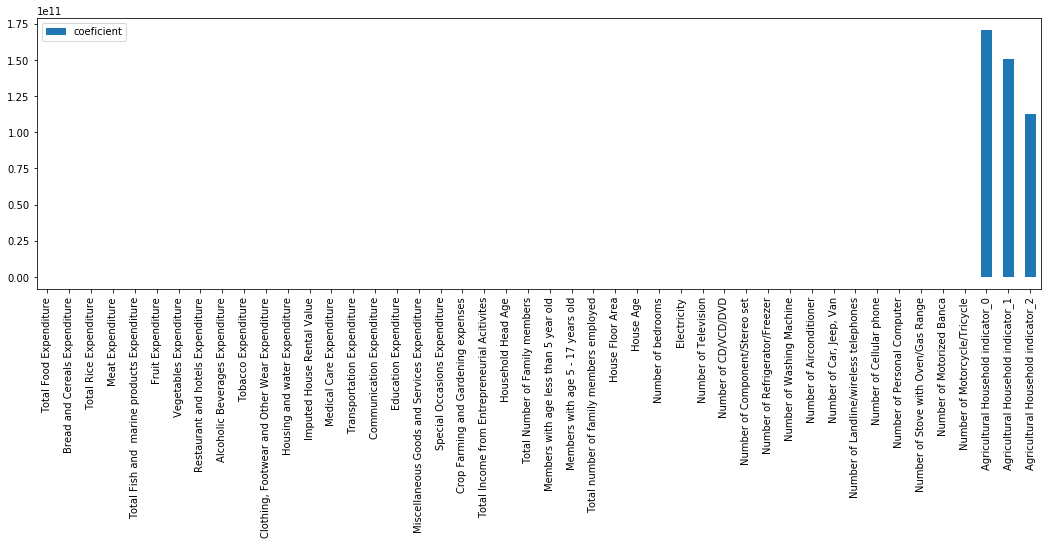

In [17]:
pd.DataFrame(lr.coef_, columns=['coeficient'], 
             index=data_number_a[mask].drop(["Total Household Income"], 
                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))

### 2.1.3. Second Model (with calculated new variables)

In [18]:
data_number3 = pd.get_dummies(data_number3, columns=["Agricultural Household indicator"])

In [19]:
data_number3.head(5)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,Number of Motorcycle/Tricycle,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,480332,117848,42140,38300,24676,16806,3325,13460,3000,0,...,1,11,179182,138707,317889,0.436338,0.563662,1,0,0
1,198235,67766,17329,13008,17434,11073,2035,7833,2360,960,...,2,12,117122,68712,185834,0.369749,0.630251,1,0,0
2,82785,61609,34182,32001,7783,2590,1730,3795,4545,270,...,0,1,34604,82081,116685,0.703441,0.296559,0,1,0
3,107589,78189,34030,28659,10914,10812,690,7887,6280,480,...,0,3,52490,92992,145482,0.639199,0.360801,1,0,0
4,189322,94625,34820,30167,18391,11309,1395,11260,6400,1040,...,1,9,80777,107342,188119,0.570607,0.429393,1,0,0


In [20]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_number3.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_number3[mask].shape, data_number3[~mask].shape))

Train set shape (29197, 53), test set shape (12347, 53)


In [21]:
mean = data_number3[mask].mean()
std = data_number3[mask].std()
# Standard scaler
data_number3_scaled = (data_number3 - mean) / std

In [22]:
data_number3_scaled.head(3)

,Total Household Income,Total Food Expenditure,Bread and Cereals Expenditure,Total Rice Expenditure,Meat Expenditure,Total Fish and marine products Expenditure,Fruit Expenditure,Vegetables Expenditure,Restaurant and hotels Expenditure,Alcoholic Beverages Expenditure,...,Number of Motorcycle/Tricycle,Number of (all),Other Expenditure,Food Expenditure,Total Expenditure,Food Ex/Total Ex,Other Ex/Total Ex,Agricultural Household indicator_0,Agricultural Household indicator_1,Agricultural Household indicator_2
0,0.829444,0.636135,1.252872,1.676188,1.357092,0.802257,0.292241,2.556956,-0.523006,-0.495452,...,1.269257,0.813113,0.402659,1.818021,0.776752,0.010873,-0.010873,0.689438,-0.524852,-0.344712
1,-0.174026,-0.335599,-0.571862,-0.431731,0.661341,0.069908,-0.190914,0.853885,-0.549881,-0.058505,...,3.059869,1.011117,-0.051079,-0.087473,-0.065016,-0.411569,0.411569,0.689438,-0.524852,-0.344712
2,-0.584703,-0.455062,0.667598,1.151209,-0.265847,-1.013735,-0.305149,-0.368259,-0.458127,-0.372561,...,-0.521355,-1.166925,-0.654392,0.276475,-0.505797,1.705390,-1.705390,-1.450407,1.905232,-0.344712


In [23]:
data_number3_scaled.isnull().values.any()

False

In [24]:
lr = LinearRegression()
lr.fit(data_number3_scaled.iloc[mask, 1:], data_number3_scaled[mask]["Total Household Income"])
pred = lr.predict(data_number3_scaled.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_number3_scaled[~mask]["Total Household Income"])**2))))

RMSE = 0.5496


In [25]:
# compare
pred = pred * std["Total Household Income"] + mean["Total Household Income"]
print('RMSE = {0:.02f}'.format(np.sqrt(np.mean((pred - data_number3_scaled[~mask]["Total Household Income"])**2))))

RMSE = 352581.6851


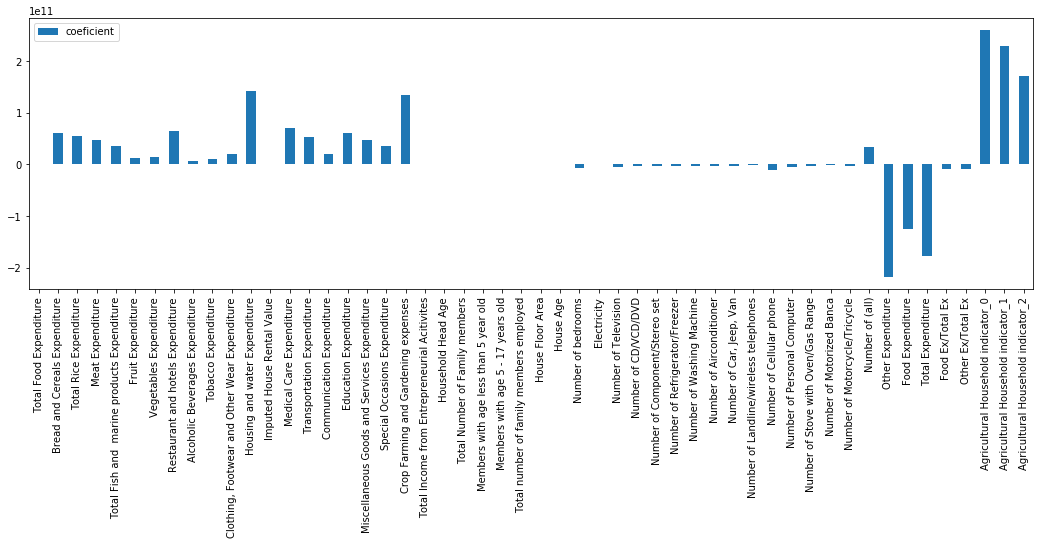

In [36]:
coef_importance = pd.DataFrame(lr.coef_, columns=['coeficient'],index=data_number3_scaled[mask].drop(["Total Household Income"], axis=1).columns)
coef_importance.plot(kind='bar', figsize=(18,5))

#coef_importance.sort_values(by = ["coeficient"]).plot(kind='bar', figsize=(18,5))

Now best performance is RMSE = 0.5496 or 352 581.69 with new columns

## Test

## 2.2. Model with all data  <font color='red'> (NEED HELP!)  </font>

In [ ]:
data_text_recode = pd.get_dummies(data_text)

In [ ]:
data_text_recode.head(3)

In [ ]:
data_number_a = pd.get_dummies(data_number, columns=["Agricultural Household indicator"])

In [ ]:
data_number_a.head(3)

In [ ]:
data_total = pd.DataFrame()
data_total = pd.concat([data_number_a, data_text_recode], axis = 1)

In [ ]:
data_text_recode.isnull().values.any()

In [ ]:
data_number_a.isnull().values.any()

In [ ]:
data_total.isnull().values.any()

In [ ]:
data_total.head(3)

In [ ]:
# split numeric data in train and test sets
np.random.seed(42)
mask = np.random.rand(data_total.shape[0]) <= 0.7
print('Train set shape {0}, test set shape {1}'.format(data_total[mask].shape, data_total[~mask].shape))

In [ ]:
sc = StandardScaler()
data_total[mask] = sc.fit_transform(data_total[mask])
data_total[mask] = pd.DataFrame(data_total[mask], index=data_total[mask].index, columns=data_total[mask].columns)
data_total[~mask] = sc.transform(data_total[~mask])

In [ ]:
data_total[mask].isnull().values.any()

In [ ]:
data_total.head(3)

In [ ]:
lr = LinearRegression()
lr.fit(data_total.iloc[mask, 1:], data_total[mask]["Total Household Income"])
pred = lr.predict(data_total.iloc[~mask, 1:])
print('RMSE = {0:.04f}'.format(np.sqrt(np.mean((pred - data_total[~mask]["Total Household Income"])**2))))

In [ ]:
#pd.DataFrame(lr.coef_, columns=['coeficient'], 
#             index=data_total[mask].drop(["Total Household Income"], 
#                                          axis=1).columns,).plot(kind='bar', figsize=(18,5))